# CSE 841 Project - FaceNet Implementation

This notebook contains a naive implementation of the [Google FaceNet](https://arxiv.org/abs/1503.03832) facial recognition neural network. It was written as a final project submission for CSE 841 at Michigan State University by *Ibrahim Ahmed*

## Helper functions

The `FaceNet` class written below encapsulates the loading of a pretrained FaceNet network using the values in the `weights` folder. The class is also responsible for loading in labeled images that are used for predictions.

The weights used in this pretrained model were obtained from [Szegedy's Inception model](https://arxiv.org/abs/1409.4842). The `inception_blocks_v2` contains an interface into this model which uses 96x96 RBG images as input and is provided by [deeplearning.ai](https://deeplearning.ai).

In [163]:
import glob
import os
from fr_utils import *
import numpy as np
import cv2
import tensorflow as tf
from inception_blocks_v2 import *
from keras import backend as K
from pathlib import Path

class FaceNet(object):
    def __init__(self):
        self._model = None
        self._faces = None


    def generate_model(self):
        K.set_image_data_format('channels_first')
        FRmodel = faceRecoModel(input_shape=(3, 96, 96))

        def loss_function(y_true, y_pred, alpha = 0.3):
            '''
            Implementation of triplet loss function
            '''
            anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

            pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,
                       positive)), axis=-1)
            neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, 
                       negative)), axis=-1)
            basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
            loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))

            return loss

        FRmodel.compile(optimizer = 'adam', loss = loss_function, metrics = ['accuracy'])
        load_weights_from_FaceNet(FRmodel)
        self._model = FRmodel

    def load_faces(self):
        self._faces = {}
        for file in glob.glob("images/processed/*"):
            name = os.path.splitext(os.path.basename(file))[0]
            self._faces[name] = img_to_encoding(file, self._model)

    
    def set_model(self, model):
        self._model = model


    def predict(self, image):
        encoding = img_to_encoding(image, self._model)

        min_dist = 100
        pred_name = None

        for (name, db_enc) in self._faces.items():
            dist = np.linalg.norm(db_enc - encoding)
#             print(f"distance for {name} is {dist}")
            if dist < min_dist:
                min_dist = dist
                pred_name = name
        if min_dist > 0.65:
            return None
        else:
            return pred_name
        
    def is_match(self, image_one_encoding, image_two_encoding):
        '''
        The minimum distance of 0.90 was hypertuned to optimize the test score
        based on the LFW test set, below you can see a curve of which min distance
        achieved the optimal score
        '''
        return np.linalg.norm(image_one_encoding - image_two_encoding) < 0.90
        
        
############ Preprocessing help

from align_dlib import *
import time
import multiprocessing as mp

align_dlib_model = AlignDlib(str(Path('./shape_predictor_68_face_landmarks.dat').absolute()))

def process_images(input_dir, output_dir, crop_dim):
    start_time = time.time()

    if not output_dir.exists():
        output_dir.mkdir()

    image_paths = input_dir.glob('*.jpg')
    for index, image_path in enumerate(image_paths):
        image_output_dir = os.path.join(output_dir, os.path.basename(os.path.dirname(image_path)))
        output_path = output_dir / image_path.name
        preprocess_image(str(image_path.absolute()), str(output_path.absolute()), crop_dim)

    print(f'Completed in {time.time() - start_time} seconds')


def preprocess_image(input_path, output_path, crop_dim):
    """
    Detect face, align and crop :param input_path. Write output to :param output_path
    :param input_path: Path to input image
    :param output_path: Path to write processed image
    :param crop_dim: dimensions to crop image to
    """
    image = _process_image(input_path, crop_dim)
    if image is not None:
        print(f'Writing processed file: {output_path}')
        cv2.imwrite(output_path, image)

def _process_image(filename, crop_dim):
    image = None
    aligned_image = None

    image = _buffer_image(filename)

    if image is not None:
        aligned_image = _align_image(image, crop_dim)
    else:
        raise IOError(f'Error buffering image: {filename}')

    return aligned_image


def _buffer_image(filename):
    print(f'Reading image: {filename}')
    image = cv2.imread(filename, )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def _align_image(image, crop_dim):
    bb = align_dlib_model.getLargestFaceBoundingBox(image)
    aligned = align_dlib_model.align(crop_dim, image, bb, landmarkIndices=AlignDlib.INNER_EYES_AND_BOTTOM_LIP)
    if aligned is not None:
        aligned = cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB)
    return aligned


########## Plotting
import matplotlib.image as mpimg

def plot_all_images_in_folder(path: Path):
    abs_path = str(path.absolute())
    directory=os.listdir(abs_path)
    plt.figure(figsize=(20,100))
    plt.title = "Images prior to centering, cropping, aligning"
    for i, file in enumerate(path.glob('*.jpg')):
        print(file.absolute())
        img = mpimg.imread(file.absolute())
        ax = plt.subplot(1, 3, i + 1)
        ax.set_title(file.name)
        plt.imshow(img)
        
########## LFW Dataset
def load_lfw_dataset(model, names):
    lfw_root = Path("./images/lfw-deepfunneled")
    dataset = {}
    for index, person_folder_path in enumerate(lfw_root.glob('**/*')):
        if person_folder_path.name[0] == '.':
            continue
            
        if person_folder_path.name not in names:
            continue

#         print(person_folder_path.name)
        dataset[person_folder_path.name] = {}
        for image in person_folder_path.glob('*.jpg'):
            image_id_number = image.name.rstrip('.jpg').split('_')[-1]
            image_id = int(image_id_number)
            aligned_image = _align_image(cv2.imread(str(image.absolute())), 96)
            if aligned_image is None:
                print(f"COULD NOT ALIGN IMAGE, SKIPPING {image}")
                continue
            dataset[person_folder_path.name][image_id] = img_matrix_to_encoding(aligned_image, model)
        if not len(dataset[person_folder_path.name]):
            del dataset[person_folder_path.name]
    return dataset
#         if index == 5:
#             return dataset
#             break

## Preprocessing test images

In [81]:
process_images(Path("./images/unprocessed"), Path("./images/processed"), 96)

Reading image: /Users/abe/c0d3/CSE-841-Project/src/images/unprocessed/abe.jpg
Writing processed file: /Users/abe/c0d3/CSE-841-Project/src/images/processed/abe.jpg
Reading image: /Users/abe/c0d3/CSE-841-Project/src/images/unprocessed/obama.jpg
Writing processed file: /Users/abe/c0d3/CSE-841-Project/src/images/processed/obama.jpg
Reading image: /Users/abe/c0d3/CSE-841-Project/src/images/unprocessed/liu.jpg
Writing processed file: /Users/abe/c0d3/CSE-841-Project/src/images/processed/liu.jpg
Completed in 9.592767000198364 seconds


### Anchor Images before pre-processing

/Users/abe/c0d3/CSE-841-Project/src/images/unprocessed/abe.jpg
/Users/abe/c0d3/CSE-841-Project/src/images/unprocessed/obama.jpg
/Users/abe/c0d3/CSE-841-Project/src/images/unprocessed/liu.jpg


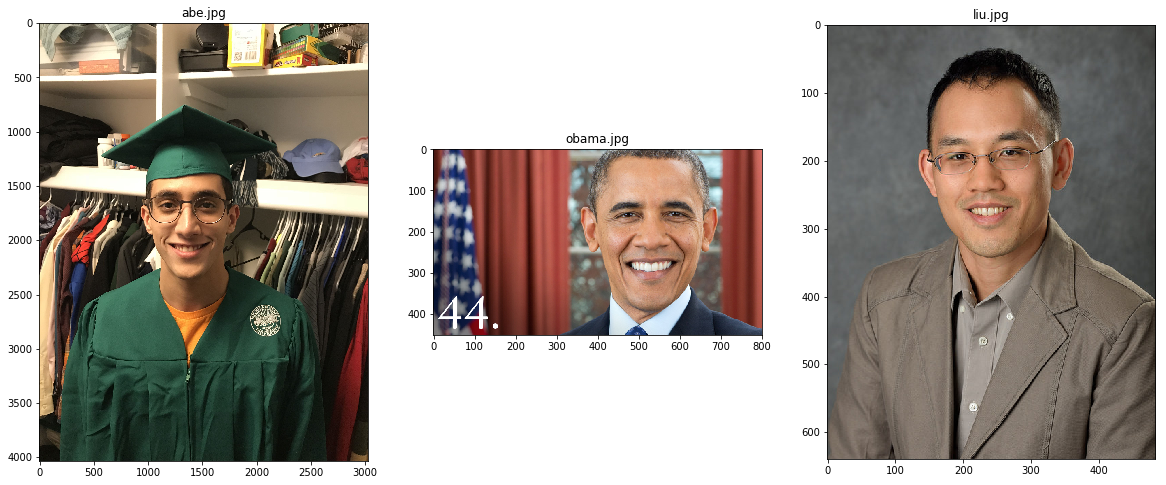

In [76]:
plot_all_images_in_folder(Path('./images/unprocessed'))

### Anchor Images after pre-processing

/Users/abe/c0d3/CSE-841-Project/src/images/processed/abe.jpg
/Users/abe/c0d3/CSE-841-Project/src/images/processed/obama.jpg
/Users/abe/c0d3/CSE-841-Project/src/images/processed/liu.jpg


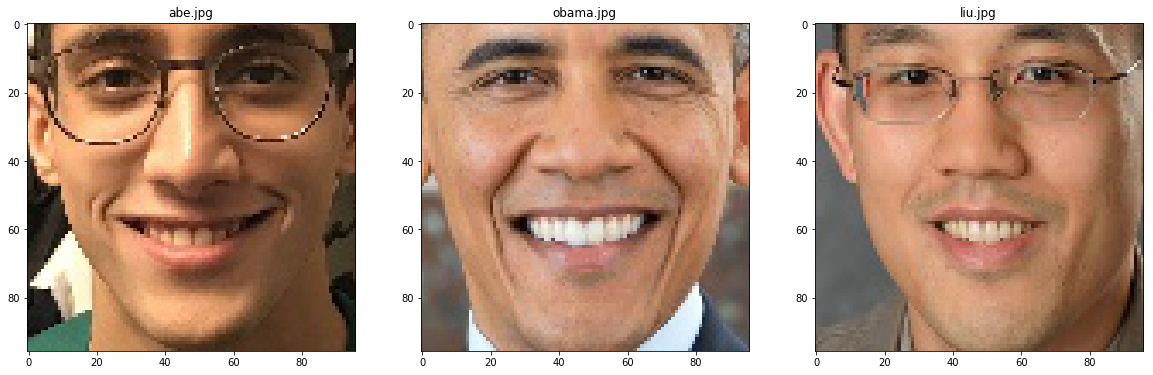

In [134]:
plot_all_images_in_folder(Path('./images/processed'))

## Compiling the FaceNet network


In [157]:
face_net = FaceNet()
# face_net.generate_model()

In [51]:
model = face_net._model
print(model)

## Matching a face

In [158]:
face_net.set_model(model)
face_net.load_faces()
print("Finished loading faces and mapping to 128 floating point numbers")

Finished loading faces and mapping to 128 floating point numbers


## Testing a face match

Now we will test the anchor images that have been mapped to the euclidean space by making predictions using our model.

### Preview of test images

/Users/abe/c0d3/CSE-841-Project/src/images/test_unprocessed/abe.jpg
/Users/abe/c0d3/CSE-841-Project/src/images/test_unprocessed/obama.jpg
/Users/abe/c0d3/CSE-841-Project/src/images/test_unprocessed/liu.jpg


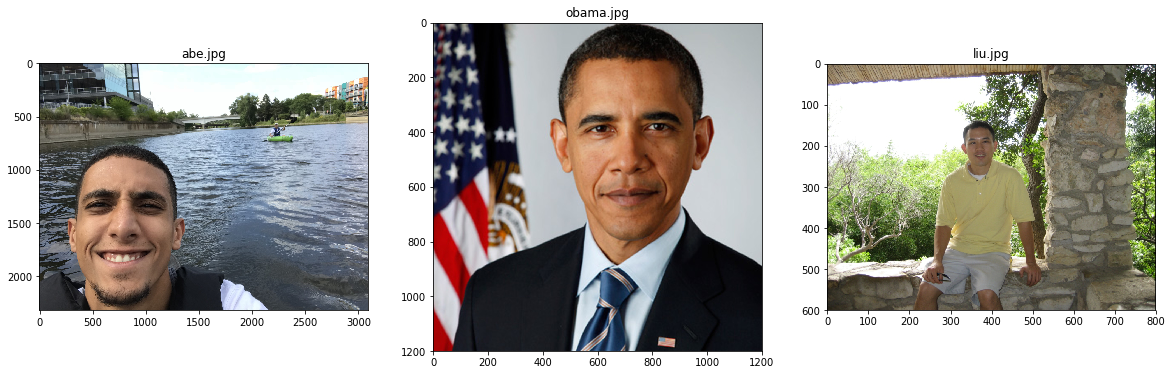

In [20]:
plot_all_images_in_folder(Path('./images/test_unprocessed'))

### Process all test images

In [135]:
process_images(Path("./images/test_unprocessed"), Path("./images/test_processed"), 96)

Reading image: /Users/abe/c0d3/CSE-841-Project/src/images/test_unprocessed/abe.jpg
Writing processed file: /Users/abe/c0d3/CSE-841-Project/src/images/test_processed/abe.jpg
Reading image: /Users/abe/c0d3/CSE-841-Project/src/images/test_unprocessed/obama.jpg
Writing processed file: /Users/abe/c0d3/CSE-841-Project/src/images/test_processed/obama.jpg
Reading image: /Users/abe/c0d3/CSE-841-Project/src/images/test_unprocessed/liu.jpg
Writing processed file: /Users/abe/c0d3/CSE-841-Project/src/images/test_processed/liu.jpg
Completed in 7.00869607925415 seconds


### Preview pre-processed test images

/Users/abe/c0d3/CSE-841-Project/src/images/test_processed/abe.jpg
/Users/abe/c0d3/CSE-841-Project/src/images/test_processed/obama.jpg
/Users/abe/c0d3/CSE-841-Project/src/images/test_processed/liu.jpg


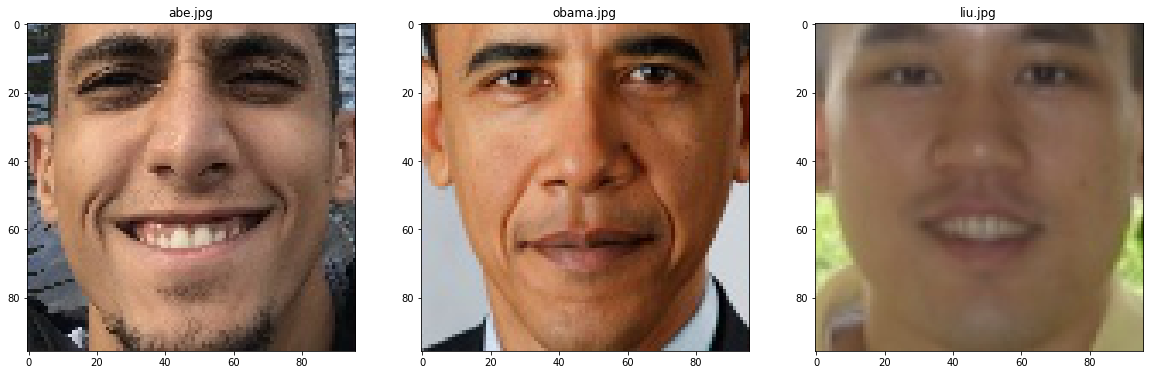

In [21]:
plot_all_images_in_folder(Path('./images/test_processed'))

### Predict on test set

In [159]:
for index, image in enumerate(Path('./images/test_processed').glob('*.jpg')):
    print(f"Predicting face found in {image}, result = {face_net.predict(str(image.absolute()))}")

Predicting face found in images/test_processed/abe.jpg, result = abe
Predicting face found in images/test_processed/obama.jpg, result = obama
Predicting face found in images/test_processed/liu.jpg, result = liu


## Evaluating prediction model on LFW Face Database

### First we'll load the LFW dataset into memory for quick access

The dataset loaded below is sourced from [here](http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz)

Each image is aligned using the dlib allignment and rescaled down to 96x96 pixels. Some images may fail to align which 

In [148]:
# cache the list of names that are needed for the test cases, saves about 1000 names from being loaded
names = set()
with open('lfw_evalutation_pairs.txt', 'r') as infile:
    for line in infile:
        params = line.split()
        if len(params) == 3:
            names.add(params[0])
        elif len(params) == 4:
            names.add(params[0])
            names.add(params[2])

lfw_dataset = load_lfw_dataset(model, names)
print(len(lfw_dataset))

5718


### Load the test cases

We will be using the LFW `View 2` collection of test pairs.

In [160]:
with open('lfw_evalutation_pairs.txt', 'r') as infile:
    first_line = None
    positive_count = 0
    positive_score = 0
    negative_count = 0
    negative_score = 0
    for line in infile:
        if not first_line:
            first_line = line
            continue
        params = line.split()
        
        is_correct = False
        
        # testing for positive match
        # sample: Woody_Allen	3	5
        if len(params) == 3:
            person = params[0]
            anchor_id = int(params[1])
            to_test_id = int(params[2])
            if person not in lfw_dataset or anchor_id not in lfw_dataset[person] or to_test_id not in lfw_dataset[person]:
                print(f"Cannot test {person} + {anchor_id} + {to_test_id}, one of the requirements is missing")
                continue
            
            positive_score += int(face_net.is_match(lfw_dataset[person][anchor_id], lfw_dataset[person][to_test_id]))
            positive_count += 1
            
        # testing for negative match
        # sample: Abdel_Madi_Shabneh	1	Giancarlo_Fisichella	1
        elif len (params) == 4:
            person = params[0]
            anchor_id = int(params[1])
            other_person = params[2]
            other_person_id = int(params[3])
            if person not in lfw_dataset or anchor_id not in lfw_dataset[person] or other_person not in lfw_dataset or other_person_id not in lfw_dataset[other_person]:
                print(f"Cannot test {person} + {anchor_id} + {other_person} + {other_person_id}, one of the requirements is missing")
                continue
                
            negative_score += int(not face_net.is_match(lfw_dataset[person][anchor_id], lfw_dataset[other_person][other_person_id]))
            negative_count += 1

        else:
            print("Unexpected line length, line follows:")
            print("'", line, "'")
            continue

Cannot test George_Galloway + 2 + 4, one of the requirements is missing
Cannot test James_Jones + 1 + 2, one of the requirements is missing
Cannot test Phil_Gramm + 1 + 2, one of the requirements is missing
Cannot test Saeb_Erekat + 1 + 2, one of the requirements is missing
Cannot test Andrew_Shutley + 1 + Saeb_Erekat + 2, one of the requirements is missing
Cannot test Brawley_King + 1 + Tom_Glavine + 2, one of the requirements is missing
Cannot test Dora_Bakoyianni + 1 + Saeb_Erekat + 2, one of the requirements is missing
Cannot test Phil_Gramm + 2 + Stefan_Tafrov + 1, one of the requirements is missing
Cannot test Chan_Gailey + 1 + 2, one of the requirements is missing
Cannot test Jelena_Dokic + 2 + 4, one of the requirements is missing
Cannot test Jelena_Dokic + 3 + 4, one of the requirements is missing
Cannot test Jelena_Dokic + 4 + 5, one of the requirements is missing
Cannot test Jelena_Dokic + 4 + 7, one of the requirements is missing
Cannot test Jelena_Dokic + 4 + 8, one of the

### Results

As seen below, the model performed fairly well on the LFW dataset. Lets plot a curve of the accuracy as we tweak the minimum distance in our `is_match` function in the next section

In [161]:
print(f"Out of {negative_count} negative samples, {float(negative_score / negative_count) * 100}% were classified correctly")
print(f"Out of {positive_count} positive samples, {float(positive_score / positive_count) * 100}% were classified correctly")

Out of 2970 negative samples, 96.16161616161617% were classified correctly
Out of 2970 positive samples, 77.74410774410775% were classified correctly
